In [1]:
import Utilities.prelude
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import k3match
from scipy.optimize import fsolve
from tqdm import tqdm
import pickle 
import math 

from src.shock_zone import shock_direction, find_prepost
from Utilities.operators import make_tree, calc_grad

# %matplotlib widget # (to go back normal %matplotlib inline)
# mpl.rcParams['figure.dpi'] = 100

In [2]:
z_chosen = 0
mach_min = 1.3
gamma = 5/3
save = False
folder = 'sedov'
snap = 'final'
m = 6
path = f'{folder}/{snap}'

if folder == 'TDE':
    is_tde = True
    epsilon = 0.03
else:
    is_tde = False
    epsilon = 0.02

In [3]:
def find_Tmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    a = 2*gamma*(gamma-1)
    minusb = gamma*2 + (ratio-6)*gamma + ratio + 1
    msquared = (minusb + np.sqrt(minusb**2 + 8*a*(gamma-1))) / (2*a)
    return np.sqrt(msquared)

def find_Pmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    msquared = (ratio * (gamma+1) + gamma - 1) / (2*gamma)
    return np.sqrt(msquared)

def find_Denmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    denom = gamma + 1 - ratio * (gamma-1)
    msquared = 2 * ratio / denom
    return np.sqrt(msquared)

def find_prepost(sim_tree, X, Y, Z, point, check_point, ds, delta, direction):
    """ Find the previous/next point along the shock direction.
    Parameters
    -----------
    point: array.
        Starting point.
    ds: array (1x3)
        Shock direction.
    delta: float.
        Step to do to search.
    direction: str.
        Choose if you want to move towards the 'pre' or 'post' shock region.
    Returns
    -----------
    idx: int.
        Tree index of the previous/next point along the shock direction.
    """
    if direction == 'post':
        delta = - delta

    k = 1
    # check that you are not taking the same point as the one given
    distance = 0
    while distance == 0:
        new_point = point + k * delta * ds 
        _, idx  = sim_tree.query(new_point)
        new_point = np.array([X[idx], Y[idx], Z[idx]])
        distance = math.dist(check_point, new_point)
        k += 0.1

    k -=0.1 #becuase you have added it in the end
    final_step = k*np.abs(delta)
    return idx, final_step


In [20]:
def ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, all_idx, idx, div, dir, direction):
    """ Start from one cell and walk along the shock direction till you go out the shock zone accoridng to Schaal14 (par 2.3.3).
    Parameters
    -----------
    sim_tree: tree.
        Simualation points. 
    X, Y, Z: arrays.
        Points coordinates.
    are_u_shock: bool array.
        Says if a simulation cell is in the shock zone.
    x_zone, y_zone, z_zone: arrays.
        Shock zone points coordinates.
    all_idx: array.
        Tree indeces identifying the cells in the shock zone.
    idx: int.
        Index of the chosen point between the one in the shock zone.
    div: array.
        Velocity divergence of the shock zone points.
    dir: 3D-array.
        Shock direction of the shock zone points.
    delta: float.
        Step you do from your chosen point. It has to be positive!
    direction: str.
        Choose if you want to move towards the 'pre' or 'post' shock region.
    Returns:
    -----------
    final_tree_index: int.
        Tree index of the pre/post shock cell corresponding to the starting one.
    """
    # Take the necessary info of your starting point 
    x_point = x_zone[idx]
    y_point = y_zone[idx]
    z_point = z_zone[idx]   
    point = np.array([x_point, y_point, z_point])
    r_point = np.linalg.norm(point)
    div_v = div[idx]
    dir_sh = np.array(dir[idx])
    
    _, _, dist = k3match.cartesian(X,Y,Z, x_point, y_point, z_point, 2*r_point)
    dist = np.delete(dist, np.argmin(dist))
    delta = np.min(dist)
    
    # Walk till you go out the shock zone
    check_zone = True 
    check_point = point
    while check_zone == True:
        # Find the next point
        i_tree, final_step = find_prepost(sim_tree, X, Y, Z, point, check_point, dir_sh, delta, direction)

        # check if it's in the shock zone
        check_zone = are_u_shock[i_tree]

        if check_zone == True:
            # there will be a index in all_idx equal to i_tree. Find it. 
            idx_zone = np.argmin(np.abs(i_tree-all_idx))  
            # Take the div and dir of that (shock zone) point.
            div_next = div[idx_zone]
            dir_next = dir[idx_zone]

            # if lower div v, you discard the ray.
            if div_next < div_v:
                return False # and then you don't take this cell

            # if opposite direction in shocks, you turn/stop.
            if np.dot(dir_sh, dir_next) < 0:
                check_zone = False # so you exit from the while
        
        check_point = np.array([X[i_tree], Y[i_tree], Z[i_tree]])
        delta = final_step
 
    final_tree_index = i_tree
    
    return final_tree_index

def shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, x_zone, y_zone, z_zone, all_idx, div, dir, cross_section = False):
    """ 
    Find among the cells in the shock zone the one in the shock surface 
    (output: indeces referring to the shockzonefile) 
    and its pre/post shock cells (output: tree indeces).
    """
    surface_Tmach = []
    surface_Pmach = []
    surface_Denmach = []

    #indeces referring to the shockzone file: you use them on xyz_zone and dir
    indeces = [] 
    # indeces referring to the list of ALL simulation cells: you use them on XYZ
    indeces_pre = []
    indeces_post = []

    # loop over all the cells in the shock zone
    for idx in range(len(x_zone)):
        print(idx)
        
        if cross_section:
            if np.abs(z_zone[idx]-z_chosen)>epsilon:
                continue

        post_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, 
                                     all_idx, idx, div, dir, direction = 'post')
        if post_tree_index == False:
            continue
        else:
            Tpost = Temp[post_tree_index]
            pre_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, 
                                        all_idx, idx, div, dir, direction = 'pre')
            if pre_tree_index == False:
                continue
            else:
                Tpre = Temp[pre_tree_index]

                Tbump = Tpost/Tpre
                # check if the Tbump is in the same direction of ds 
                if Tbump < 1:
                    continue 

                # We should also avoid the cells with Tbump< than the one (1.2921782544378697) inferred from M=M_min... So condition 2 doesn't work in shock zone?
                if Tbump < 1.292:
                    continue 

                indeces.append(idx)
                indeces_pre.append(pre_tree_index)
                indeces_post.append(post_tree_index)

                # def temperature_bump(mach):
                #     to_solveT =  ((gamma-1) * mach**2 + 2) * (2 * gamma * mach**2 - (gamma-1)) / ((gamma+1)**2 * mach**2) - Tbump
                #     return to_solveT
                
                Ppre = Press[pre_tree_index]
                Ppost = Press[post_tree_index]
                Pbump = Ppost/Ppre
                Denpre = Den[pre_tree_index]
                Denpost = Den[post_tree_index]
                Denbump = Denpost/Denpre

                # def pressure_bump(mach):
                #     to_solveP = (2 * gamma * mach**2 - (gamma-1)) / (gamma+1) - Pbump
                #     return to_solveP

                # def density_bump(mach):
                #     to_solverho = (gamma+1) * mach**2 / (mach**2 * (gamma-1) + 2) - Denbump
                #     return to_solverho
                
                Tmach = find_Tmach(Tbump, gamma)
                Pmach = find_Pmach(Pbump, gamma)
                Denmach = find_Denmach(Denbump, gamma)
                #Tmach = fsolve(temperature_bump, 1.5)
                # Pmach = fsolve(pressure_bump, 1.5)
                #Denmach = fsolve(density_bump, 1.5)

                surface_Tmach.append(Tmach)
                surface_Pmach.append(Pmach)
                surface_Denmach.append(Denmach)
            
    surface_Tmach = np.array(surface_Tmach)
    surface_Pmach = np.array(surface_Pmach)
    surface_Denmach = np.array(surface_Denmach)
    indeces = np.array(indeces)
    indeces_pre = np.array(indeces_pre)
    indeces_post = np.array(indeces_post)

    return surface_Tmach, surface_Pmach, surface_Denmach, indeces, indeces_pre, indeces_post


In [21]:
# Import data
with open(f'data/{snap}/shockbool_{snap}.pkl', 'rb') as filebool:
    are_u_shock = pickle.load(filebool)
    
shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
shockdir = np.loadtxt(f'data/{snap}/shockdir_{snap}.txt')

x_zone = shockzone[0]
y_zone = shockzone[1]
z_zone = shockzone[2]
div = shockzone[3]
Tzone = shockzone[4]
idx_tree = shockzone[5]

x_dir = shockdir[0]
y_dir = shockdir[1]
z_dir = shockdir[2]
dir = []
for i in range(len(x_dir)):
    dir.append([x_dir[i], y_dir[i], z_dir[i]])

In [22]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path, snap, is_tde)
dim_cell = (3*Vol/(4*np.pi))**(1/3)

all T=0, bro. Compute by myself!


In [23]:
surface_Tmach, surface_Pmach, surface_Denmach, indeces, indeces_pre, indeces_post = shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, x_zone, y_zone, z_zone, idx_tree, div, dir)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [24]:
if save == True:
    #surface_mach_txt = np.concatenate(surface_Tmach)
    with open(f'data/{snap}/shocksurface_{snap}.txt', 'w') as file:
        file.write(f'# Indeces of the shock zone points that are in the shock surface (I.E. they refer to the shockzone file) \n') 
        file.write(' '.join(map(str, indeces)) + '\n')
        file.write('# mach number according to T jump\n') 
        file.write(' '.join(map(str, surface_Tmach)) + '\n')
        file.write('# mach number according to P jump\n') 
        file.write(' '.join(map(str, surface_Pmach)) + '\n')
        file.write('# mach number according to Den jump\n') 
        file.write(' '.join(map(str, surface_Denmach)) + '\n')
        file.write(f'# Tree indeces of the pre shock zone points corresponding to the shock surface points \n') 
        file.write(' '.join(map(str, indeces_pre)) + '\n')
        file.write(f'# Tree indeces of the post shock zone points corresponding to the shock surface points \n') 
        file.write(' '.join(map(str, indeces_post)) + '\n')
        file.close()
    

In [25]:
surface_x = x_zone[indeces]
surface_y = y_zone[indeces]
surface_z = z_zone[indeces]
surface_dirx = x_dir[indeces]
surface_diry = y_dir[indeces]

post_x = X[indeces_post]
post_y = Y[indeces_post]
post_z = Z[indeces_post]
pre_x = X[indeces_pre]
pre_y = Y[indeces_pre]
pre_z = Z[indeces_post]


In [26]:
# Cross section
zone_cross_x = x_zone[np.abs(z_zone-z_chosen)< epsilon]
zone_cross_y = y_zone[np.abs(z_zone-z_chosen)< epsilon]

surface_cross_x = surface_x[np.abs(surface_z-z_chosen)<epsilon]
surface_cross_y = surface_y[np.abs(surface_z-z_chosen)<epsilon]

cross_shockdirx = surface_dirx[np.abs(surface_z-z_chosen)<epsilon]
cross_shockdiry = surface_diry[np.abs(surface_z-z_chosen)<epsilon]

zone_post_x = post_x[np.logical_and(np.abs(surface_z-z_chosen)<epsilon, np.abs(post_z-z_chosen)<epsilon)] # post_x[np.abs(surface_z-z_chosen)<epsilon] 
zone_post_y = post_y[np.logical_and(np.abs(surface_z-z_chosen)<epsilon, np.abs(post_z-z_chosen)<epsilon)] # post_y[np.abs(surface_z-z_chosen)<epsilon]

zone_pre_x = pre_x[np.logical_and(np.abs(surface_z-z_chosen)<epsilon, np.abs(pre_z-z_chosen)<epsilon)] # pre_x[np.abs(surface_z-z_chosen)<epsilon]
zone_pre_y = pre_y[np.logical_and(np.abs(surface_z-z_chosen)<epsilon, np.abs(pre_z-z_chosen)<epsilon)] # pre_y[np.abs(surface_z-z_chosen)<epsilon]


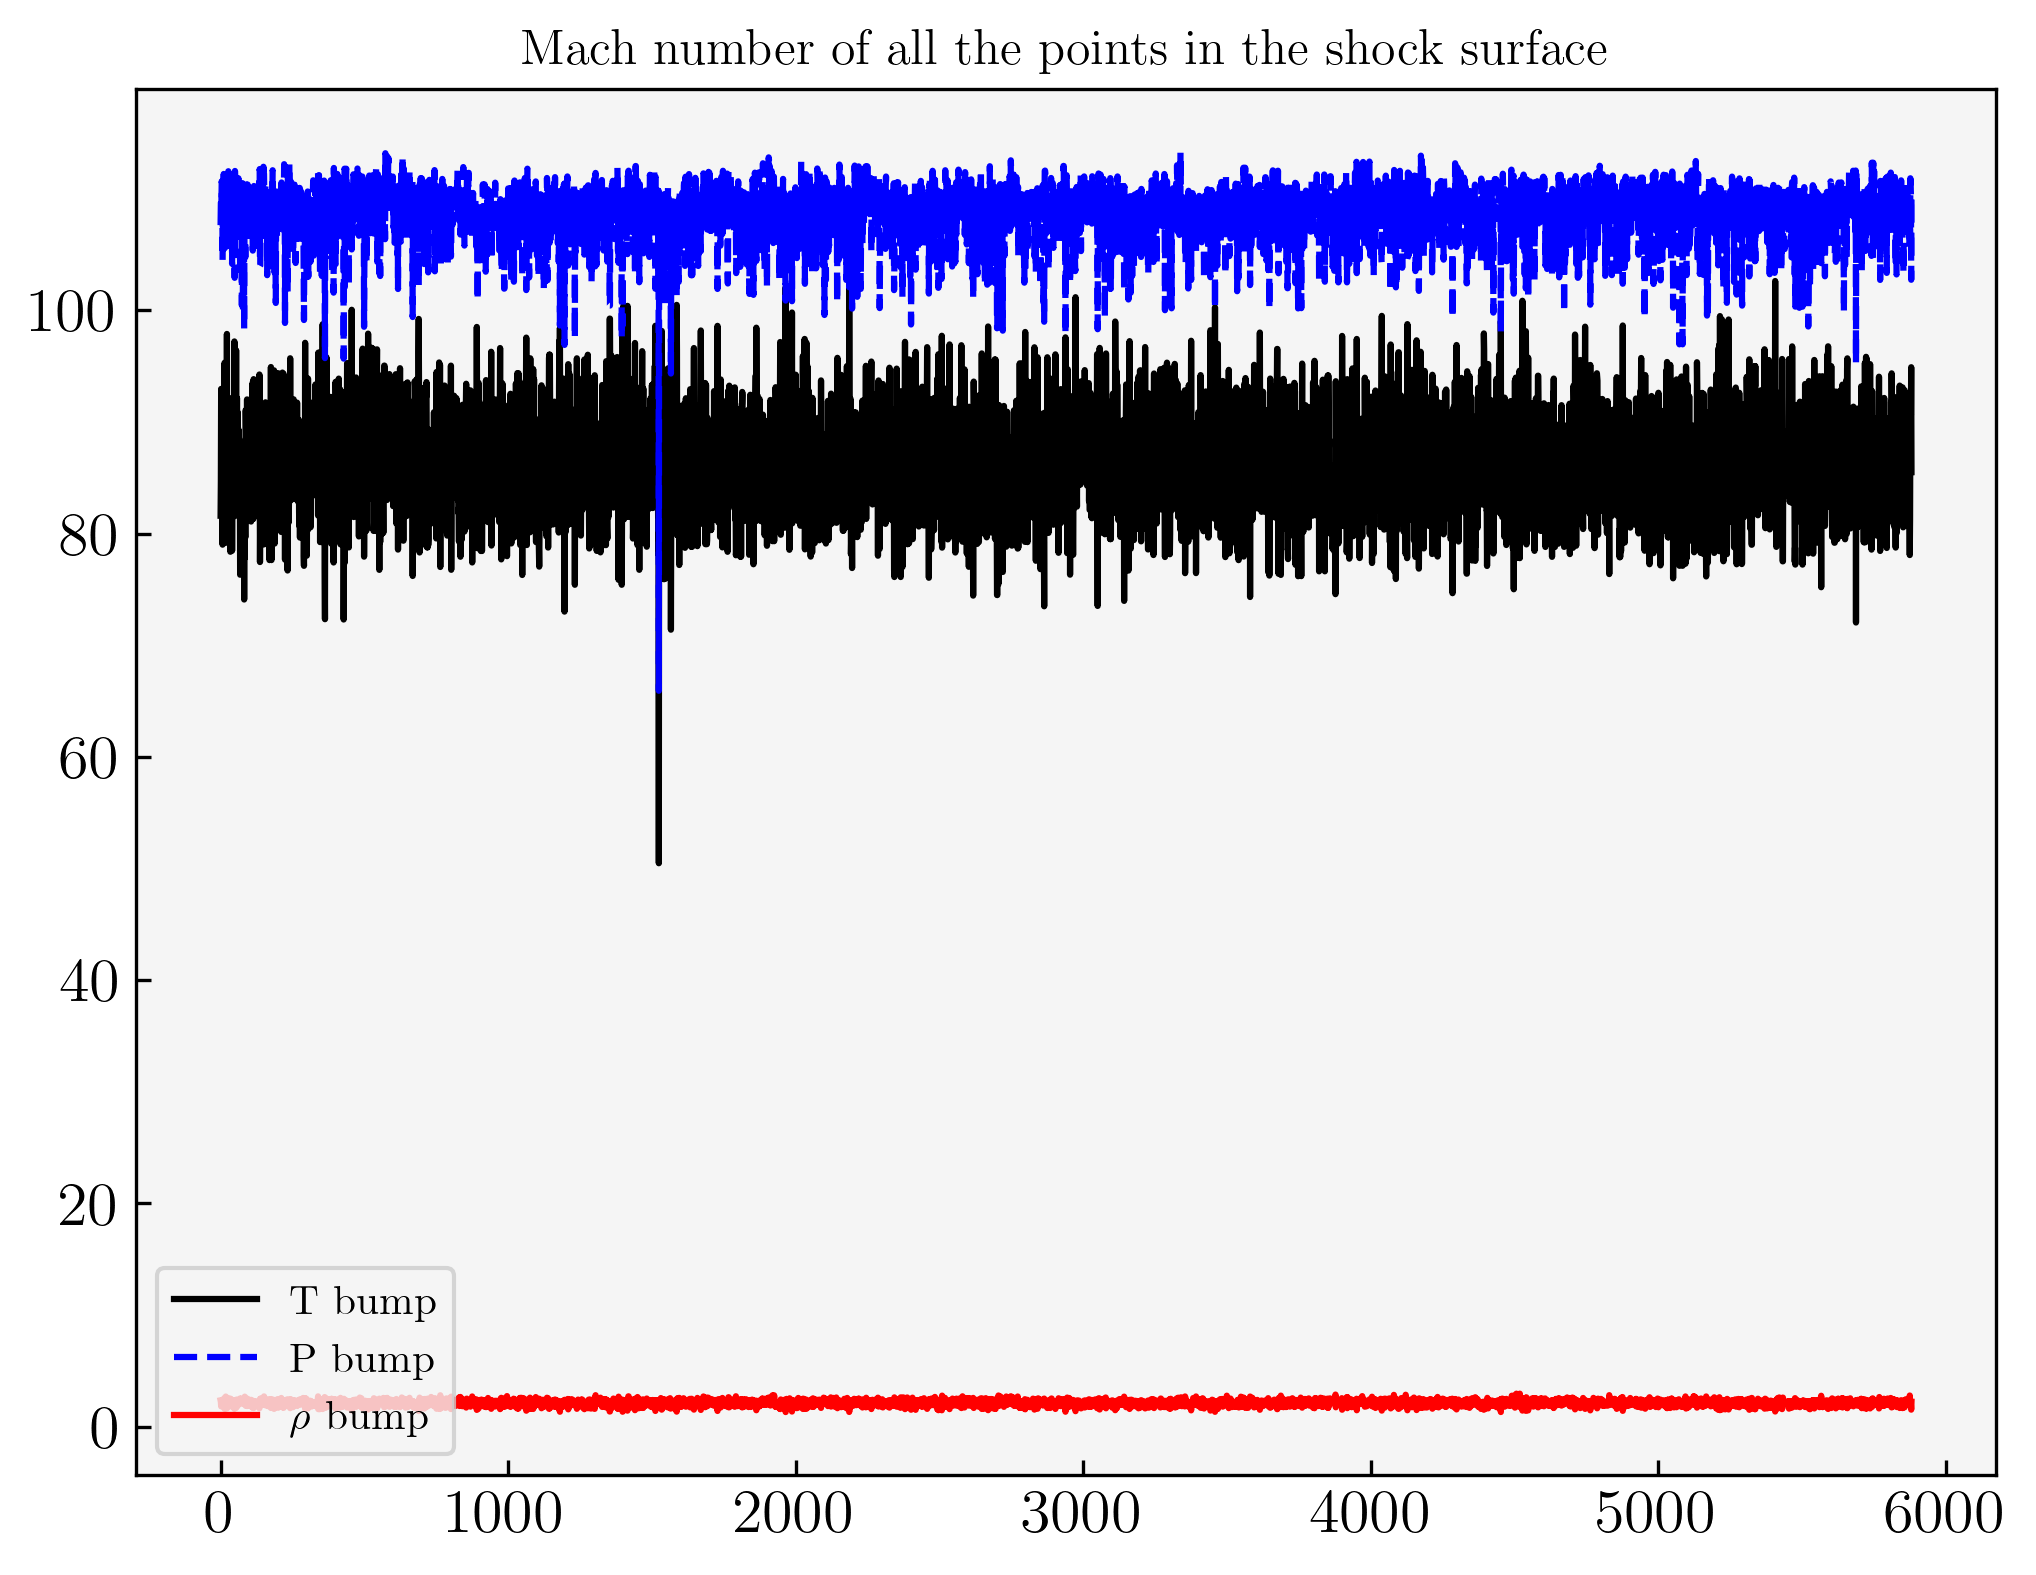

In [27]:
plt.plot(surface_Tmach, c = 'k', label = 'T bump')
plt.plot(surface_Pmach, c = 'b', linestyle = '--', label = 'P bump')
plt.plot(surface_Denmach, c = 'r',  label = r'$\rho$ bump')
plt.title(f'Mach number of all the points in the shock surface')
plt.legend(loc = 'lower left')
if save:
    plt.savefig(f'Figs/{snap}/mach{snap}.png')

In [28]:
# plt.plot(surface_Tmach[np.abs(surface_z-z_chosen)<epsilon], c = 'k')
# # plt.scatter(outlier, surface_mach[np.logical_and(surface_z<z_chosen+step, surface_z>z_chosen-step)][outlier], c = 'r')
# plt.ylabel(r'$\mathcal{M}$', fontsize = 15)
# plt.title(f'Mach number at z= {z_chosen}')
# if save == True:
#   plt.savefig(f'Figs/{snap}/mach{snap}_z{z_chosen}.png')
# plt.show()

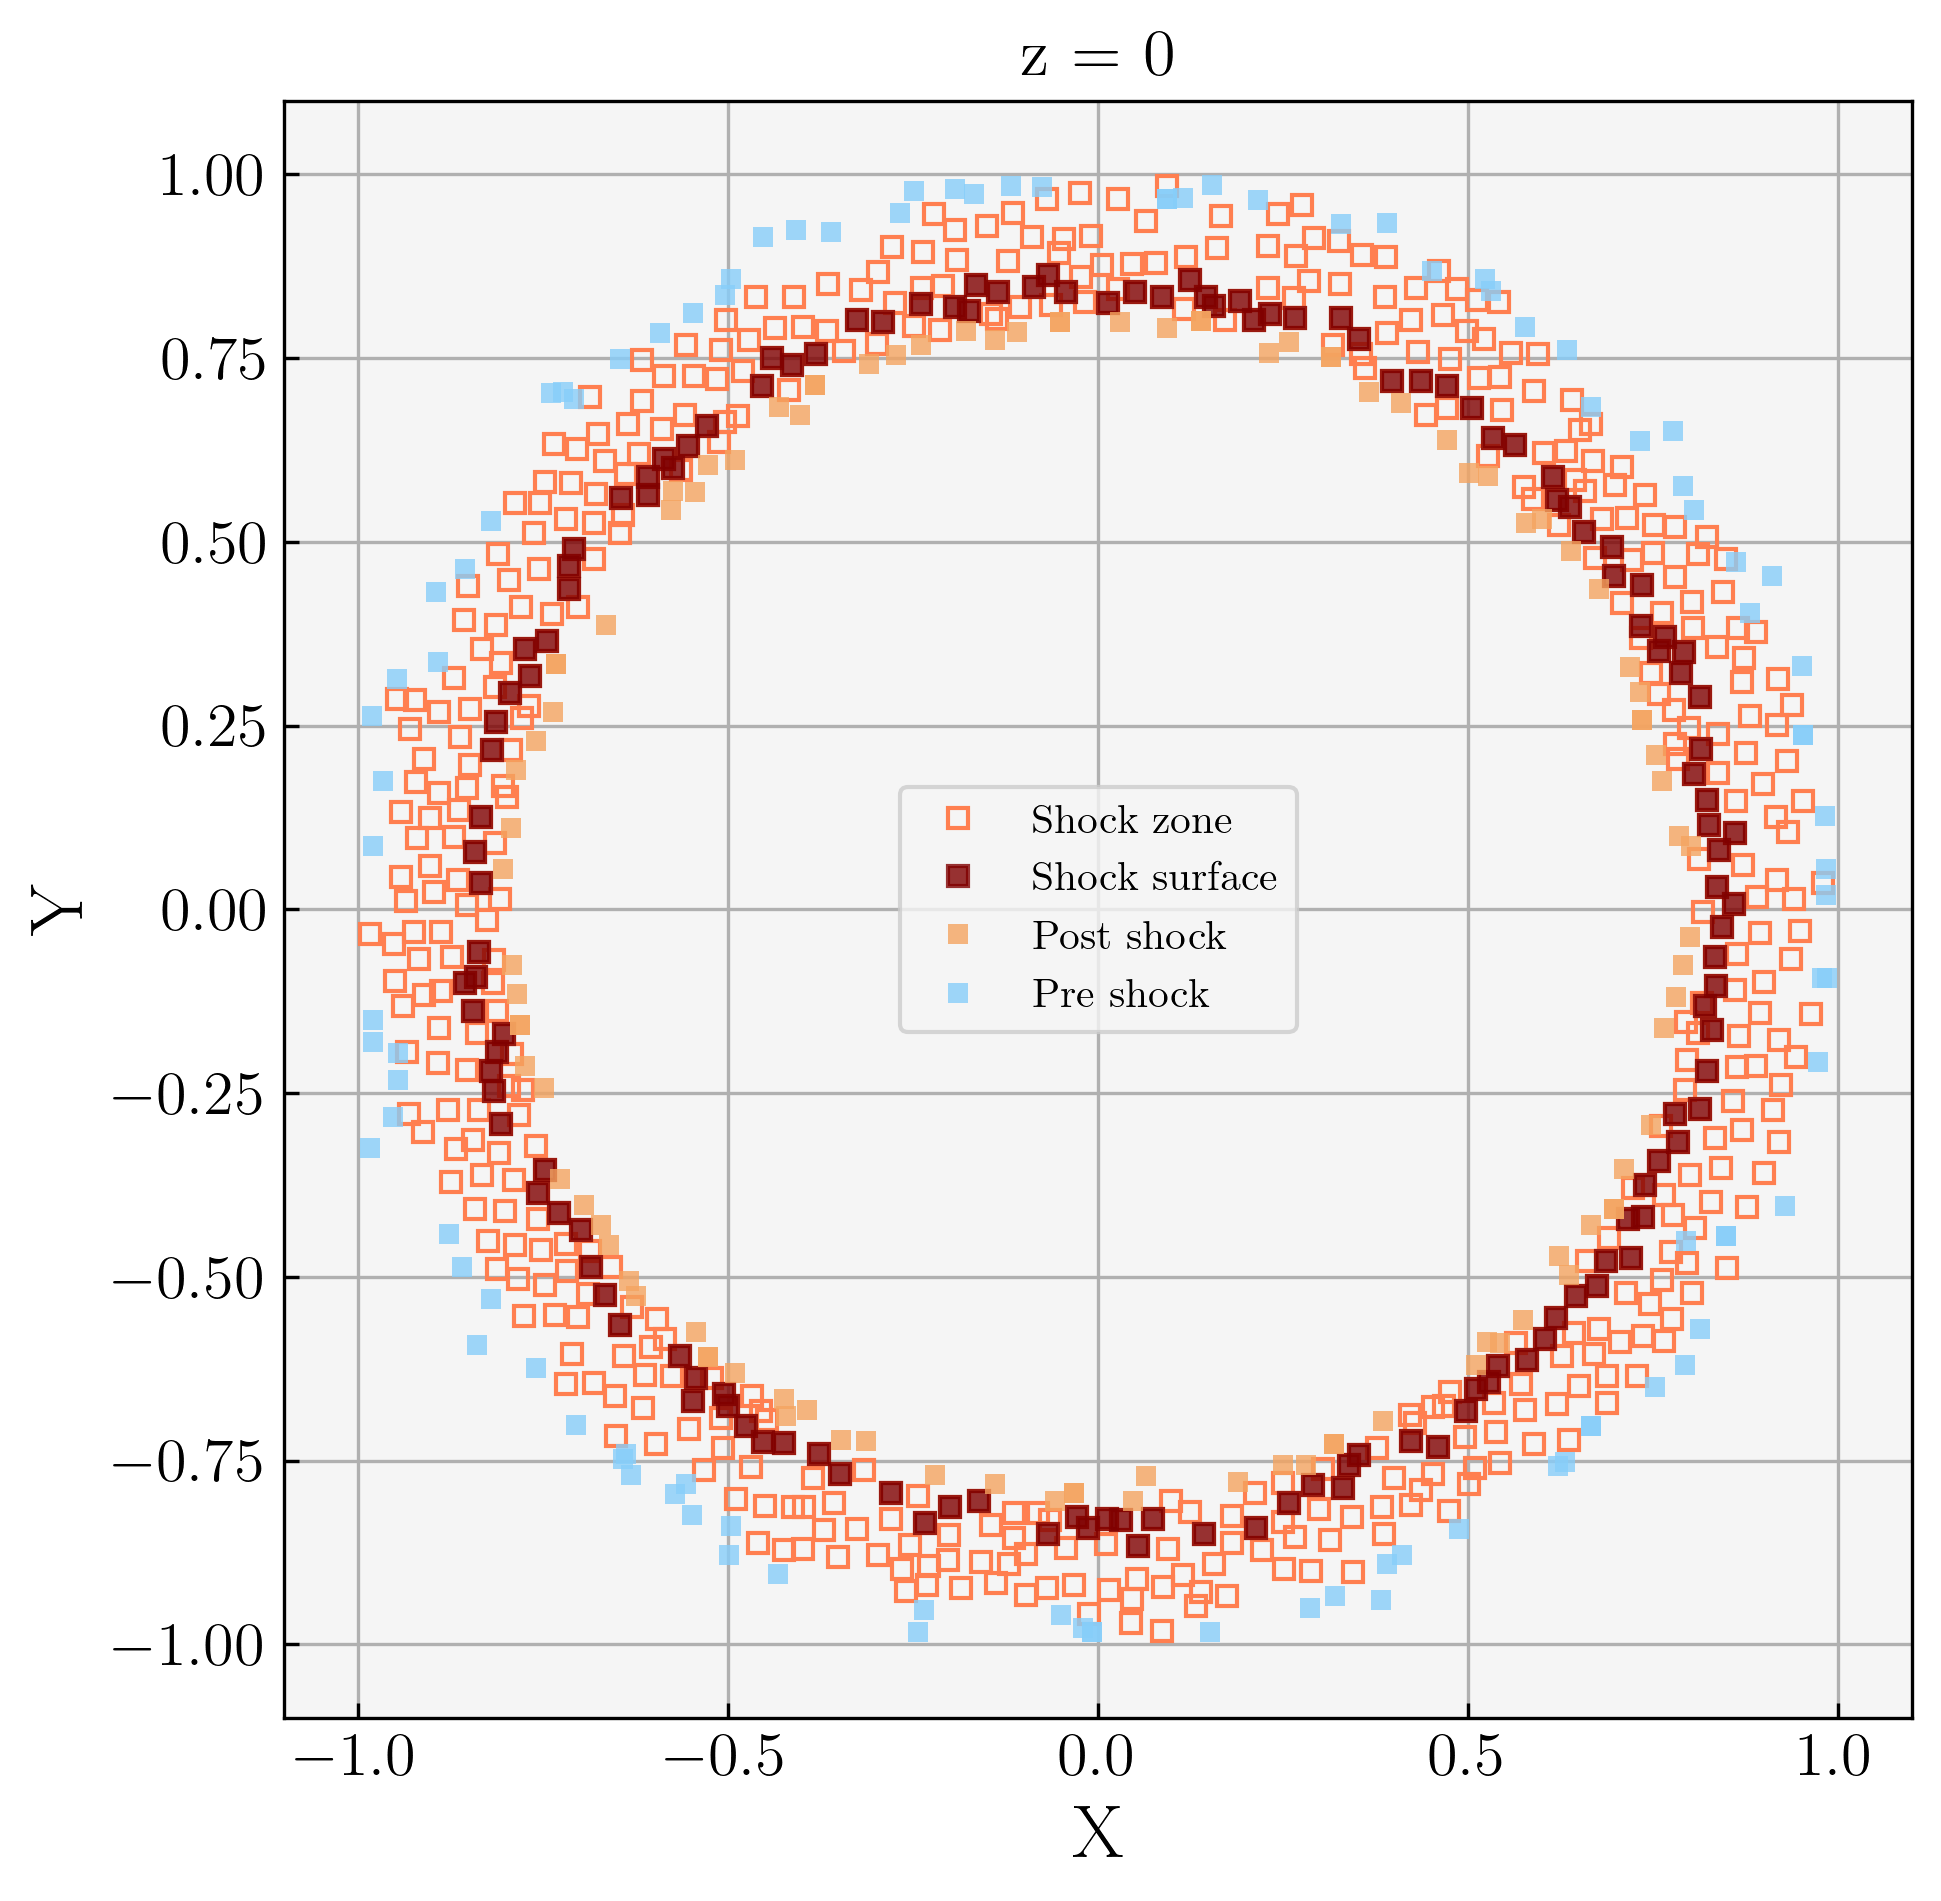

In [29]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
if folder == 'sedov':
    fig, ax = plt.subplots(1,1, figsize = (7,7))
    ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='coral', label = 'Shock zone')
    ax.plot(surface_cross_x, surface_cross_y, 'ks', markerfacecolor='maroon', ms = 5, markeredgecolor='maroon',  alpha = 0.8, label = 'Shock surface')

    #ax.quiver(surface_cross_x, surface_cross_y, cross_shockdirx, cross_shockdiry, color = 'k', angles='xy', scale_units='xy', scale = 2)
    ax.plot(zone_post_x, zone_post_y, 'ks', markerfacecolor='sandybrown', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Post shock')
    ax.plot(zone_pre_x, zone_pre_y, 'ks', markerfacecolor='lightskyblue', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Pre shock')

    # ax.plot(surface_cross_x[outlier], surface_cross_y[outlier], 'ks', markerfacecolor='r', ms = 7, markeredgecolor='r',  label = 'outlier')
    # ax.plot(post_x[slice_surface][outlier], post_y[slice_surface][outlier], 'ks', markerfacecolor='orange', ms = 7, markeredgecolor='orange',  label = 'outlier post')
    # ax.plot(pre_x[slice_surface][outlier], pre_y[slice_surface][outlier], 'ks', markerfacecolor='b', ms = 7, markeredgecolor='b',  label = 'outlier pre')

    if folder == 'sedov':
        ax.set_xlim(-1.1,1.1)
        ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    ax.legend()
    ax.set_title(f'z = {z_chosen}', fontsize = 16)
    plt.grid()
    if save == True:
        plt.savefig(f'Figs/{snap}/5shocksurface_z{z_chosen}_{snap}.png')


In [30]:
print(surface_Tmach)

[81.595416   84.6481132  92.95449957 ... 90.59708837 94.8954683
 85.49866186]


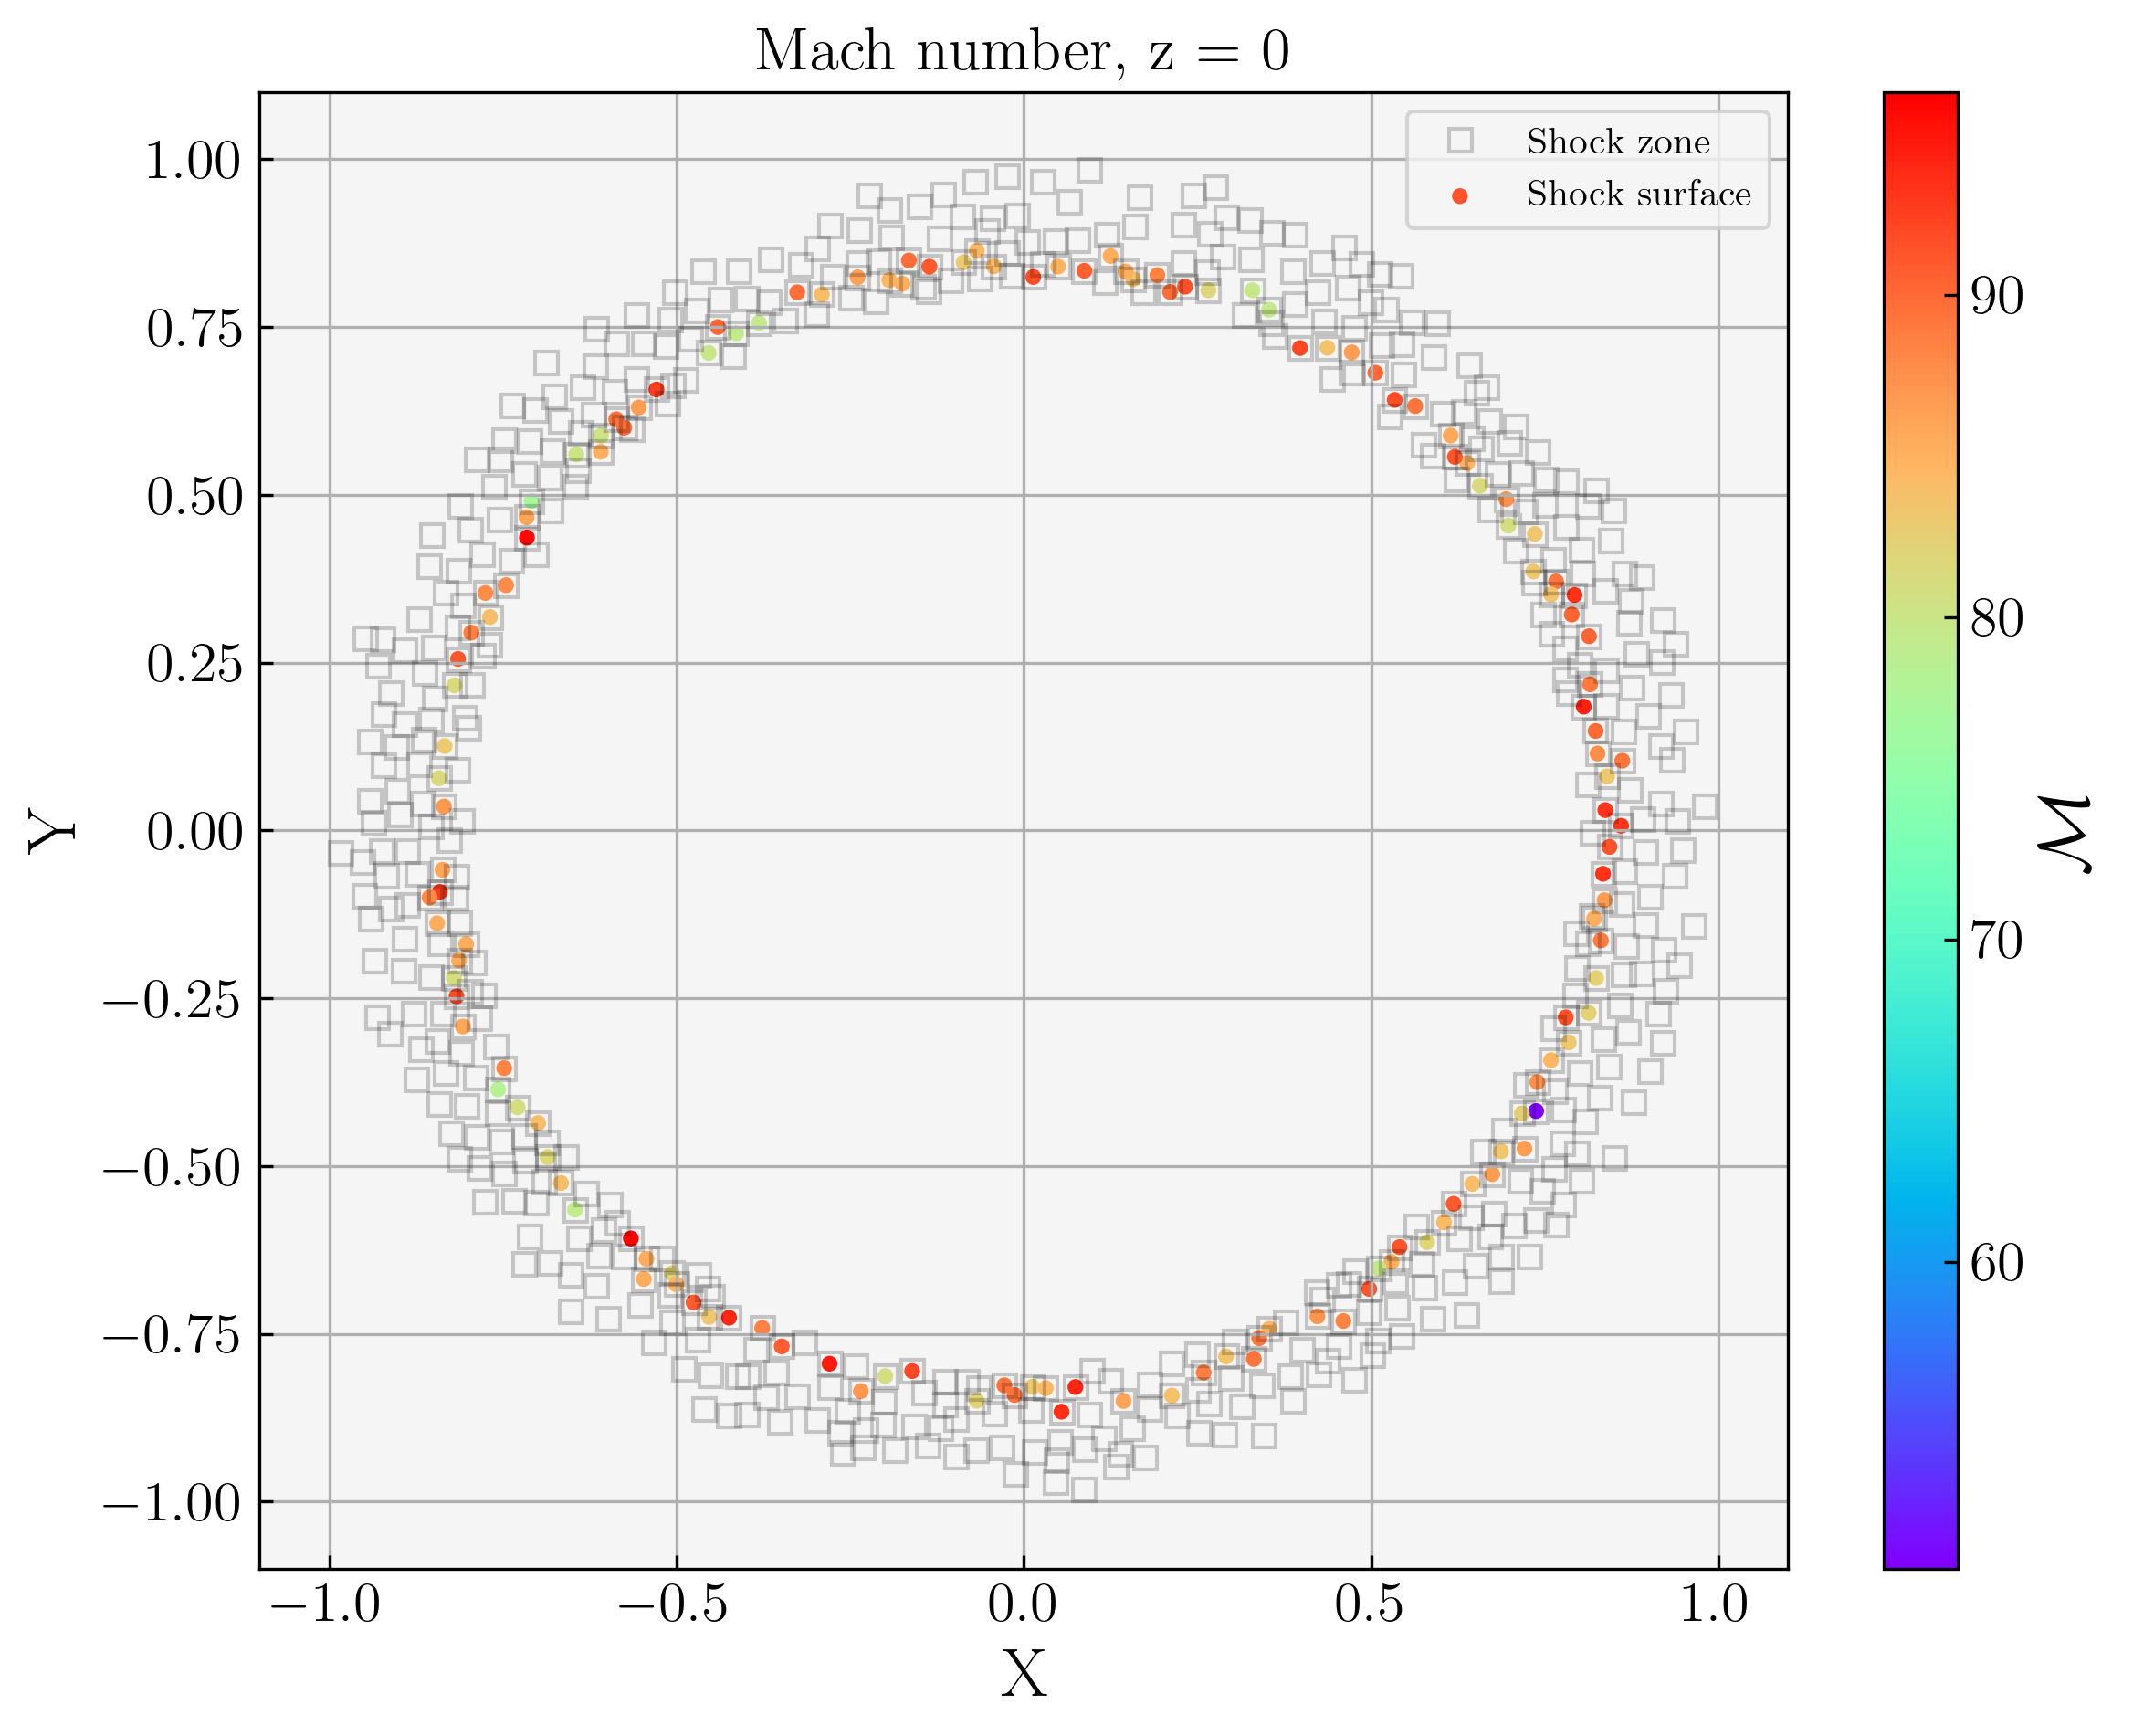

In [31]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
if folder == 'sedov':
    fig, ax = plt.subplots(1,1, figsize = (9,7))
    ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 6, markeredgecolor='k', alpha = 0.2, label = 'Shock zone')
    img = ax.scatter(surface_cross_x, surface_cross_y, c = surface_Tmach[np.abs(surface_z-z_chosen)<epsilon], s=10,  cmap = 'rainbow', label = 'Shock surface')#, vmin = 110, vmax = 160)
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    ax.set_title(f'Mach number, z = {z_chosen}', fontsize = 16)
    ax.legend()
else: 
    Mbh = 10**m 
    Rt =  Mbh**(1/3) # Msol = 1, Rsol = 1
    apocenter = 2 * Rt * Mbh**(1/3)
    fig, ax = plt.subplots(1,1, figsize = (14,7))
    img = ax.scatter(surface_x/apocenter, surface_y/apocenter, c = surface_Tmach, label = 'Shock surface', cmap = 'rainbow', vmin=1, vmax = 8)
    plt.ylim(-0.3, 0.2)
    plt.xlim(-1,0.05)
    plt.xlabel(r'X [x/$R_a$]', fontsize = 18)
    plt.ylabel(r'Y [y/$R_a$]', fontsize = 18)
cbar = plt.colorbar(img)
cbar.set_label(r'$\mathcal{M}$', fontsize = 19)
plt.grid()
if save == True:
    if folder == 'sedov':
        plt.savefig(f'Figs/{snap}/5shocksurfaceMach_z{z_chosen}_{snap}.png')
    else:
        plt.savefig(f'Figs/{snap}/5shocksurfaceMach_{snap}.png')
plt.show()